🔊 Original Audio:


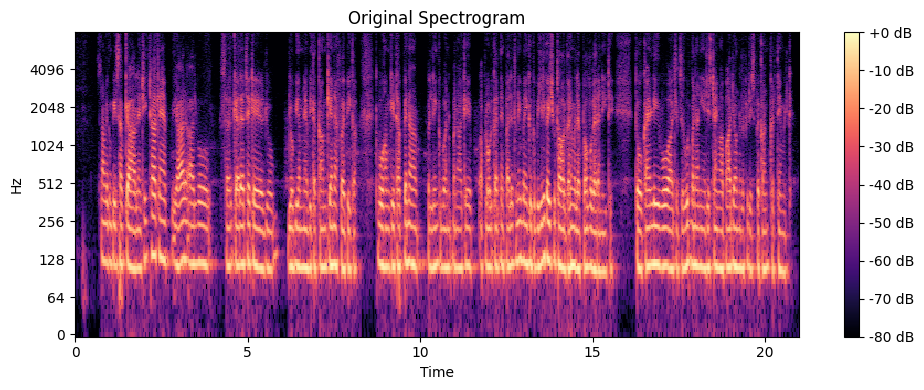

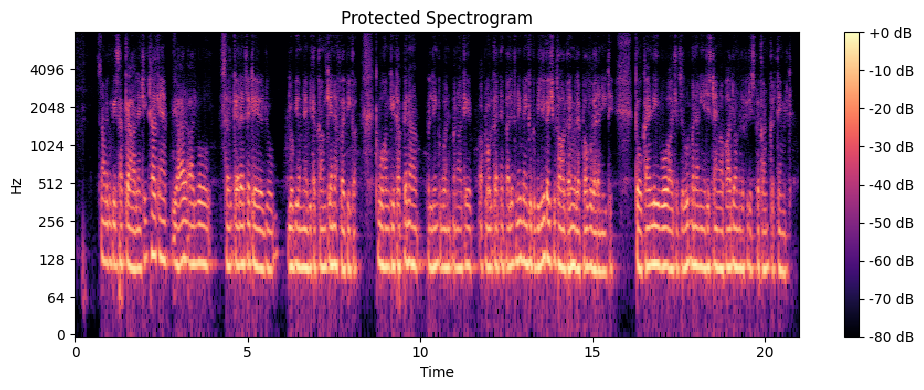

📊 Cosine similarity (original vs protected): 0.5258
🛡️ Protected Audio:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import Audio, display
from scipy.signal import butter, lfilter
from scipy.ndimage import gaussian_filter1d
from google.colab import files

# Band-pass filter for shaping the noise
def band_pass_filter(data, sr, lowcut=None, highcut=None):
    nyquist = 0.5 * sr
    if lowcut is None:
        lowcut = int(nyquist * 0.6)
    if highcut is None or highcut >= nyquist:
        highcut = int(nyquist * 0.95)
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    return lfilter(b, a, data)

# Add imperceptible noise only during high-pitch voiced regions
def add_smart_noise(audio, sr, noise_strength=0.0005):
    f0, voiced_flag, _ = librosa.pyin(audio,
                                      fmin=librosa.note_to_hz('C2'),
                                      fmax=librosa.note_to_hz('C7'),
                                      sr=sr)

    pitch_mask = np.interp(np.arange(len(audio)),
                           np.linspace(0, len(audio), num=len(f0)),
                           (voiced_flag * (f0 > 300)).astype(float))

    # Smooth the mask to avoid harsh transitions
    pitch_mask = gaussian_filter1d(pitch_mask, sigma=5)

    raw_noise = np.random.randn(len(audio))
    band_limited_noise = band_pass_filter(raw_noise, sr)

    shaped_noise = noise_strength * pitch_mask * band_limited_noise

    return audio + shaped_noise

# Smoothed pitch shift for voiced regions only
def pitch_shift_voiced(audio, sr, n_steps=0.2):
    f0, voiced_flag, _ = librosa.pyin(audio,
                                      fmin=librosa.note_to_hz('C2'),
                                      fmax=librosa.note_to_hz('C7'),
                                      sr=sr)

    frame_length = 2048
    hop_length = 512
    output = np.zeros(len(audio))
    window = np.hanning(frame_length)
    overlap_count = np.zeros(len(audio))

    for i in range(0, len(audio) - frame_length, hop_length):
        idx = i // hop_length
        is_voiced = voiced_flag[idx] if idx < len(voiced_flag) else False
        segment = audio[i:i+frame_length]

        if is_voiced:
            shifted = librosa.effects.pitch_shift(segment, sr=sr, n_steps=n_steps)
        else:
            shifted = segment

        shifted_windowed = shifted * window
        output[i:i+frame_length] += shifted_windowed
        overlap_count[i:i+frame_length] += window

    nonzero_mask = overlap_count > 0
    output[nonzero_mask] /= overlap_count[nonzero_mask]

    return output

# Spectrogram visualization
def plot_spectrogram(audio, sr, title="Spectrogram"):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Cosine similarity
def compare_audio_similarity(original, protected):
    min_len = min(len(original), len(protected))
    original, protected = original[:min_len], protected[:min_len]
    sim = cosine_similarity(original.reshape(1, -1), protected.reshape(1, -1))[0][0]
    return sim

# Protection pipeline
def protect_audio(audio_path):
    audio, sr = librosa.load(audio_path, sr=None, mono=True)

    print("🔊 Original Audio:")
    display(Audio(audio, rate=sr))

    # Voiced pitch shift
    shifted_audio = pitch_shift_voiced(audio, sr, n_steps=0.2)

    # Add smart noise
    protected_audio = add_smart_noise(shifted_audio, sr)

    # Normalize
    protected_audio = protected_audio / np.max(np.abs(protected_audio))

    # Spectrograms
    plot_spectrogram(audio, sr, "Original Spectrogram")
    plot_spectrogram(protected_audio, sr, "Protected Spectrogram")

    # Cosine similarity
    similarity = compare_audio_similarity(audio, protected_audio)
    print(f"📊 Cosine similarity (original vs protected): {similarity:.4f}")

    print("🛡️ Protected Audio:")
    display(Audio(protected_audio, rate=sr))

    # Save and download
    protected_path = "protected_audio.wav"
    sf.write(protected_path, protected_audio, sr)
    files.download(protected_path)

    return protected_audio, similarity

# Run
audio_path = '/content/original1.ogg'  # Change if needed
protected_audio, similarity = protect_audio(audio_path)
